# Deep neural networking training performance estimation (TPE)
This notebook shows an example of Training Performance Estimation (TPE) based on logfiles from training a PyTorch model. TPE uses Training Speed Estimation (TSE), which is a simple, efficient, and computationally cheap method to estimate final test performance based on training speed. It does not require hyperparameter-tuning, training data collection, or surrogate model training.

TPE requires a logfile with 'epoch' and 'train_loss_step' columns. The logfile must including *training* loss for every step (loss after every minibatch).

A suitable logfile is easy to generate with PyTorch Lightning by adding the following line to the `training_step` method of your `LightningModule`:
```
self.log('train_loss',
            loss,
            on_step=True
            )
```

TPE also uses GPU utilization and GPU power data collected using the `nvidia-smi` tool to relate DNN performance to energy consumption.

[1] Ru, Robin, et al. "Speedy Performance Estimation for Neural Architecture Search." 
    Advances in Neural Information Processing Systems 34 (2021).

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
%matplotlib inline

In [61]:
df = pd.read_csv('data/metrics.csv')
df = df.dropna(subset=['train_loss_step'])[['train_loss_step', 'epoch', 'step']]

In [62]:
df.head()

,train_loss_step,epoch,step
0,73.303116,0,0
1,70.119537,0,1
2,69.118813,0,2
3,66.436890,0,3
4,60.837421,0,4


In [63]:
df.tail()

,train_loss_step,epoch,step
1943,3.147081,29,1885
1944,4.167433,29,1886
1945,3.883977,29,1887
1946,3.260770,29,1888
1947,3.825483,29,1889


In [64]:
df_energy = pd.read_csv('data/nvidia-smi.csv')
df_energy = df_energy[['timestamp', ' index', ' utilization.gpu [%]',
       ' utilization.memory [%]', ' power.draw [W]']]
df_energy.describe()

,index,utilization.gpu [%],utilization.memory [%],power.draw [W]
count,85670.000000,85670.000000,85670.000000,85670.000000
mean,0.500000,24.758293,3.543014,43.927812
std,0.500003,23.370498,3.810124,15.505347
min,0.000000,0.000000,0.000000,24.500000
25%,0.000000,0.000000,0.000000,25.910000
50%,0.500000,31.000000,3.000000,49.380000
75%,1.000000,40.000000,5.000000,56.360000
max,1.000000,100.000000,16.000000,79.310000


`E` controls the number of "burn-in" epochs that are discarde from the beginning of training in the TSE-E estimator, and `gamma` is a decay rate for the TSE-EMA estimator. Recommended values from the paper are used as defaults.

In [65]:
from tpe import TrainingSpeedEstimator

estimator = TrainingSpeedEstimator(E=1, gamma=0.999)

The TSE values can be used to predict the rank order of the performance of different architectures or hyperparameter configurations, or to directly predict the performance of a network trained to convergence.

In [66]:
tpe_dict = estimator.estimate(df, 10, df_energy=df_energy) # use up to first 10 epochs for estimation
tpe_dict

{'tse': 129.8276312691825,
 'tsee': 5.670970326378232,
 'tseema': 134.53728970599116,
 'T_end': 30.0,
 'energy_per_epoch (kJ)': 0.7100424525,
 'energy_per_step (kJ)': 0.011270515119047619}

Show training loss as a function of energy budget.

In [68]:
eps = tpe_dict['energy_per_step (kJ)']

df['energy_consumed'] = (df['step'] + 1) * eps


Text(0.5, 0, 'Total energy consumed (kJ)')

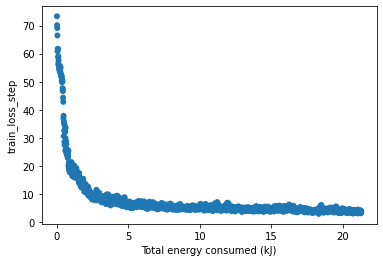

In [69]:

fig = sns.scatterplot(data=df, x='energy_consumed', y='train_loss_step', edgecolor='none',
                    )
plt.xlabel('Total energy consumed (kJ)')